In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# import zipfile

# # Unzip the archive into the "datasets" folder
# local_zip = './merged-datasets.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall()
# zip_ref.close()

In [6]:
# Directory Management for Raw Image datasets
data_dir_raw_image = 'datasets/raw image'
data_dir_raw_image = pathlib.Path(data_dir_raw_image)
raw_durian_images_dict = {
    'ripe' : list(data_dir_raw_image.glob('ripe/*')),
    'unripe' : list(data_dir_raw_image.glob('unripe/*')),
} 
raw_durian_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}
list(data_dir_raw_image.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/raw image/ripe/ripe_0.jpg'),
 WindowsPath('datasets/raw image/ripe/ripe_1.jpg'),
 WindowsPath('datasets/raw image/ripe/ripe_10.jpg'),
 WindowsPath('datasets/raw image/ripe/ripe_11.jpg'),
 WindowsPath('datasets/raw image/ripe/ripe_12.jpg')]

In [7]:
# Directory Management for Gas datasets
data_dir_gas = 'datasets/aroma'
data_dir_gas = pathlib.Path(data_dir_gas)
durian_gas_dict = {
    'ripe' : list(data_dir_gas.glob('ripe/*')),
    'unripe' : list(data_dir_gas.glob('unripe/*')),
} 
gas_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}
list(data_dir_gas.glob('*/*.png'))[:5]

[WindowsPath('datasets/aroma/ripe/heatmap_10_percobaan_1.png'),
 WindowsPath('datasets/aroma/ripe/heatmap_10_percobaan_2.png'),
 WindowsPath('datasets/aroma/ripe/heatmap_10_percobaan_3.png'),
 WindowsPath('datasets/aroma/ripe/heatmap_10_percobaan_4.png'),
 WindowsPath('datasets/aroma/ripe/heatmap_10_percobaan_5.png')]

In [9]:
X_raw, y_raw = [], []
output_folder = "resized_images"
for durian_ripeness, images in raw_durian_images_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(200,200))
        X_raw.append(resized_img)
        y_raw.append(raw_durian_labels_dict[durian_ripeness])
        # Uncomment if you want to check all the resized images
        # output_name = f"{durian_ripeness}_{index}.jpg"
        # output_path = os.path.join(output_folder, output_name)
        # cv2.imwrite(output_path, resized_img)
X_raw = np.array(X_raw)
y_raw = np.array(y_raw)
len(y_raw)

100

In [10]:
X_gas, y_gas = [], []
for durian_ripeness, images in durian_gas_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(200,200))
        X_gas.append(resized_img)
        y_gas.append(gas_labels_dict[durian_ripeness])
X_gas = np.array(X_gas)
y_gas = np.array(y_gas)
y_gas
len(y_gas)

100

In [11]:
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, train_size=0.7)
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(X_gas, y_gas, train_size=0.7)

# Scaling Raw dataset
X_train_scaled_raw = X_train_raw /255
X_test_scaled_raw = X_test_raw /255
# Scaling Gas dataset
X_train_scaled_gas = X_train_gas /255
X_test_scaled_gas = X_test_gas /255

In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

input_shape_raw = (200, 200, 3)  
input_shape_gas = (200, 200, 3)  

# Define two separate input layers
input_raw = Input(shape=input_shape_raw)
input_gas = Input(shape=input_shape_gas)

In [14]:
convDim = 3  # Define the convolution dimension

In [15]:
# Convolution layer for Raw dataset
conv1_raw = Conv2D(16, (convDim, convDim), activation='relu', input_shape=input_shape_raw)(input_raw)
pool1_raw = MaxPooling2D(2, 2)(conv1_raw)

conv2_raw = Conv2D(32, (convDim, convDim), activation='relu')(pool1_raw)
pool2_raw = MaxPooling2D(2, 2)(conv2_raw)

flat_raw = Flatten()(pool2_raw)

In [17]:
# Convolution layer for Gas dataset
conv1_gas = Conv2D(16, (convDim, convDim), activation='relu', input_shape=input_shape_gas)(input_gas)
pool1_gas = MaxPooling2D(2, 2)(conv1_gas)

conv2_gas = Conv2D(32, (convDim, convDim), activation='relu')(pool1_gas)
pool2_gas = MaxPooling2D(2, 2)(conv2_gas)

flat_gas = Flatten()(pool2_gas)

In [18]:
# Concatenate the flattened outputs
merged = concatenate([flat_raw, flat_gas])

In [19]:
# Fully Connected Layer
fc2 = Dense(64, activation='relu')(merged)
drop_fc2 = Dropout(0.5)(fc2)
output = Dense(1, activation='sigmoid')(drop_fc2)

# Create the model
model = Model(inputs=[input_raw, input_gas], outputs=output)

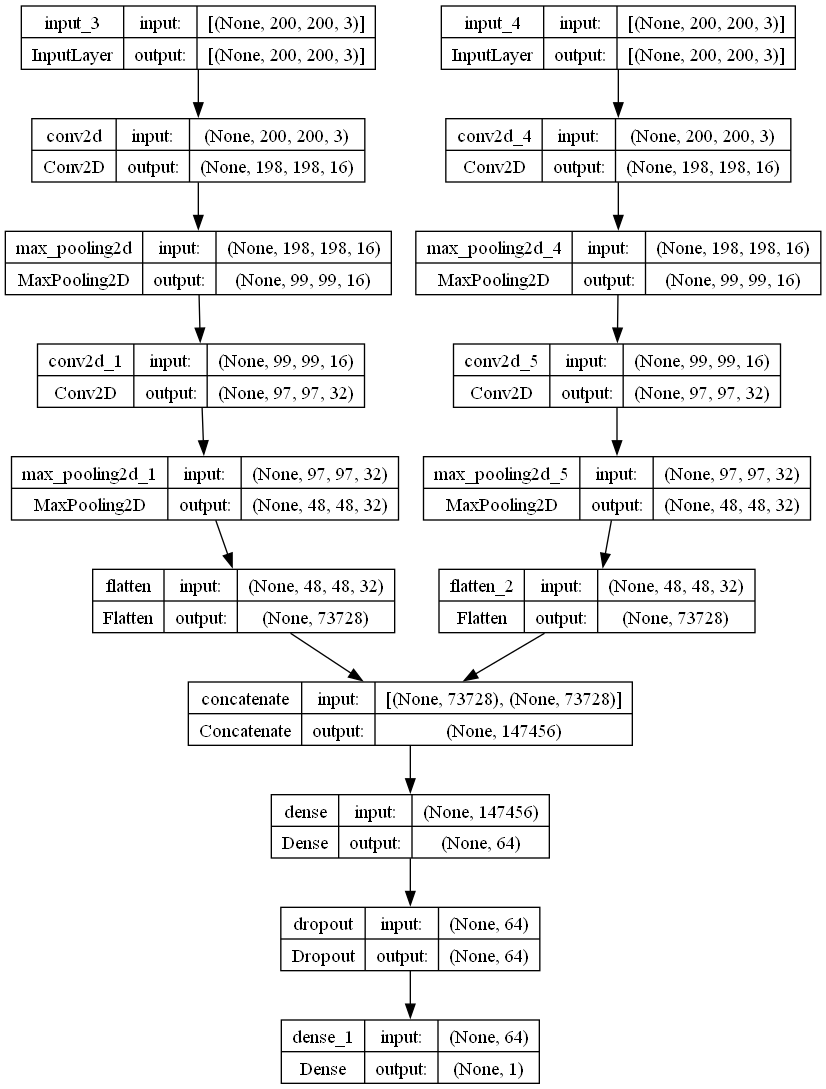

In [23]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)
from tensorflow.keras.utils import plot_model

# Print model summary
# model.summary()
plot_model(model, to_file='custom-cnn.png', show_shapes=True, show_layer_names=True)

In [24]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check the loss
    if(logs.get('accuracy') == 1.0):

      # Stop if threshold is met
      print("\nAccuracy is reached than 1.0 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()
# callbacks=callbacks

In [25]:
# Train the model
model_fit = model.fit(
 ( X_train_scaled_raw, X_train_scaled_gas), 
 y_train_raw, 
 batch_size=3, 
 epochs=25,
 validation_data=(
        ( X_test_scaled_raw, X_test_scaled_gas), 
        ( y_test_raw, y_test_gas)
    ),
#  callbacks=callbacks
 )

Epoch 1/25
11/24 [============>.................] - ETA: 11s - loss: 2.3319 - accuracy: 0.4242

KeyboardInterrupt: 

In [24]:
loss, accuracy = model.evaluate([X_test_scaled_raw, X_test_scaled_gas], [y_test_raw, y_test_gas])
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 574ms/step - accuracy: 0.8104 - loss: 0.5897
Test Loss: 0.4621782898902893
Test Accuracy: 0.824999988079071


In [25]:
predictions = model.predict([X_test_scaled_raw, X_test_scaled_gas])
predictions = np.round(predictions,2)
predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 518ms/step


array([[0.  ],
       [0.99],
       [0.  ],
       [1.  ],
       [0.94],
       [0.  ],
       [0.  ],
       [1.  ],
       [1.  ],
       [0.85],
       [1.  ],
       [1.  ],
       [1.  ],
       [0.06],
       [0.  ],
       [0.99],
       [1.  ],
       [0.9 ],
       [0.99],
       [0.94],
       [1.  ],
       [1.  ],
       [0.45],
       [1.  ],
       [1.  ],
       [1.  ],
       [0.98],
       [1.  ],
       [0.02],
       [0.55],
       [0.  ],
       [1.  ],
       [0.  ],
       [0.  ],
       [0.2 ],
       [1.  ],
       [0.34],
       [1.  ],
       [1.  ],
       [0.  ]], dtype=float32)

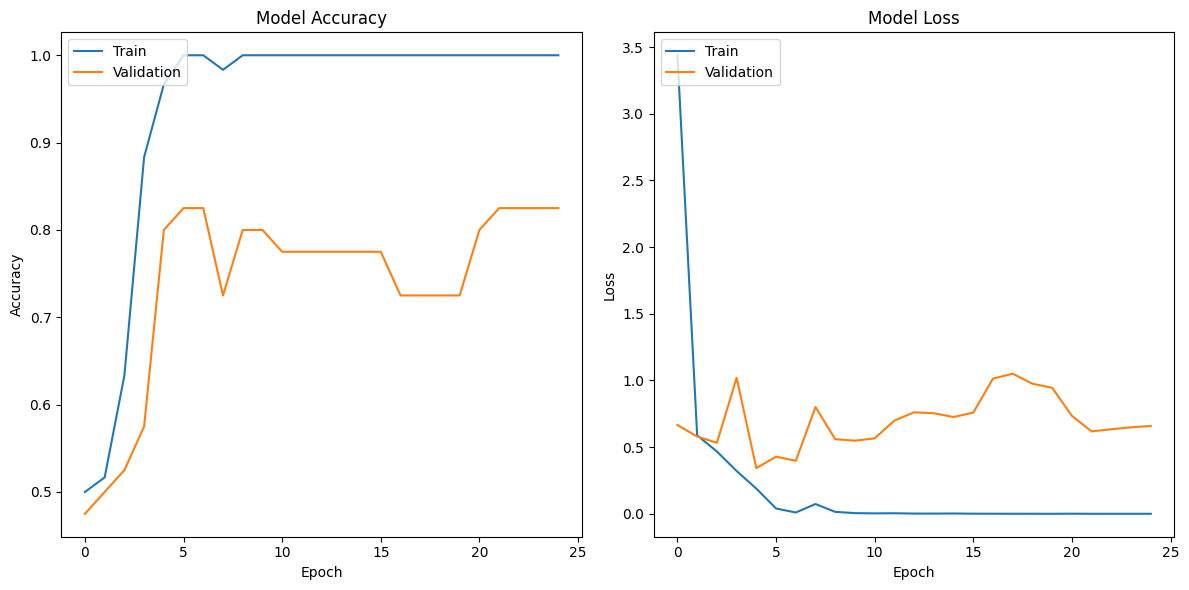

In [26]:
# Plot training and validation history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])  # Add validation accuracy
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])  # Add validation loss
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step


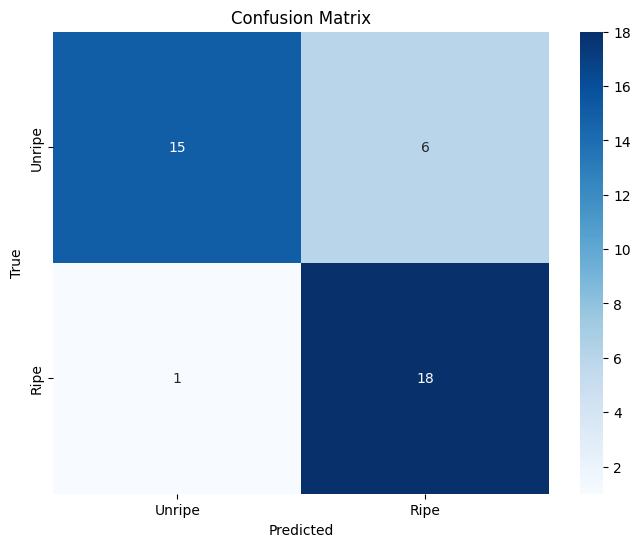

In [27]:
# Generate predictions on the test set
y_pred = model.predict([X_test_scaled_raw, X_test_scaled_gas])
y_pred_classes = (y_pred > 0.9).astype(int)  # Assuming it's a binary classification problem

# Generate the confusion matrix
conf_mat = confusion_matrix(y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()